# Prototype for the PFU_counter detector

In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import math
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchsummary import summary # cannot make it work

In [2]:
# Dataset class

class LabDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])

        image = Image.open(image_path)
        image = image.transpose(Image.ROTATE_270)
        image = image.convert("RGB")
        image_width, image_height = image.size
        # This is in relative coordinate
        df = pd.read_csv(label_path, sep=" ", names=["label", "cx","cy","w","h"])
        df["label"] += 1 # label 0 must be background
        df2 = df.copy(deep=True)
        df2.columns = ["label", "x1", "y1", "x2", "y2"]
        df2["x1"] = (df["cx"] - df["w"]/2.0)*image_width
        df2["y1"] = (df["cy"] - df["h"]/2.0)*image_height
        df2["x2"] = (df["cx"] + df["w"]/2.0)*image_width
        df2["y2"] = (df["cy"] + df["h"]/2.0)*image_height
        boxes = df2[["x1", "y1", "x2", "y2"]].values.tolist()
        labels = df["label"].values.tolist()
        area = (df["w"]*image_width*df["h"]*image_height).values.tolist()

        image = transforms.functional.to_tensor(image)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = torch.as_tensor(area)

        target = {}
        target["labels"] = labels
        target["boxes"] = boxes
        target["image_id"] = image_id
        target["area"] = area

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

In [3]:
# Use the GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data directory
image_dir = "/home/valentin/Desktop/richardLab/side_projects/PFU_counter/data/lab_raw_good"
label_dir = "/home/valentin/Desktop/richardLab/side_projects/PFU_counter/data/lab_raw_good_labels"

# transform = Compose([RandomHorizontalFlip(0.5), GaussianBlur(3)])
# dataset = LabDataset(image_dir, label_dir, transform=transform)
dataset = LabDataset(image_dir, label_dir)

# Tensorboard writter
writer = SummaryWriter('runs/Run_without_augmentation')

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Split the dataset
train_set, test_set = torch.utils.data.random_split(dataset, [31, 5])

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [6]:
# The model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4  # background + the 3 others
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replacing the pre rtained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
# Model training

num_epochs = 10
n_iter = 0
for epoch in range(num_epochs):
    epoch_mean_loss = 0

    # Train
    model.train()
    for ii, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{key: t[key].to(device) for key in t.keys()} for t in targets]

        losses_dict = model(images, targets)
        losses_sum = sum(loss for loss in losses_dict.values())
        loss = losses_sum.item()

        n_iter += 1
        for key in losses_dict.keys():
            writer.add_scalar("Losses/" + key, losses_dict[key], n_iter)
        writer.add_scalar("Total_loss", loss, n_iter)

        if not math.isfinite(loss):
            print("Loss is {}, stopping training".format(loss))
            print(losses_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses_sum.backward()
        optimizer.step()

        print(f"Epoch {epoch}: total loss {loss}")

    # # Test
    # test_loss = 0
#     with torch.no_grad():
        # for images, targets in test_loader:
        #     images = list(image.to(device) for image in images)
        #     targets = [{key: t[key].to(device) for key in t.keys()} for t in targets]
        #
        #     losses_dict = model(images, targets)
        #     losses_sum = sum(loss for loss in losses_dict.values())
        #     loss = losses_sum.item()
        #     test_loss += loss
        # test_loss = test_loss / len(test_set)
        # writer.add_scalar("Total_loss/test", (epoch+1)*len(train_set))

    # update the learning rate
    lr_scheduler.step()

print("That's it!")
torch.save(model, "test_save")

Epoch 0: total loss 9.821481704711914
Epoch 0: total loss 1.940560221672058
Epoch 0: total loss 1.3143242597579956
Epoch 0: total loss 1.297799825668335
Epoch 0: total loss 1.2351926565170288
Epoch 0: total loss 0.9827947616577148
Epoch 0: total loss 0.9549559354782104
Epoch 0: total loss 0.991359531879425
Epoch 0: total loss 0.8545249104499817
Epoch 0: total loss 0.814125657081604
Epoch 0: total loss 0.9040849208831787
Epoch 0: total loss 0.8539854288101196
Epoch 0: total loss 0.6273043751716614
Epoch 0: total loss 0.706960916519165
Epoch 0: total loss 0.8645318150520325
Epoch 0: total loss 0.840929388999939
Epoch 0: total loss 0.9452701807022095
Epoch 0: total loss 0.9473468065261841
Epoch 0: total loss 0.5718953609466553
Epoch 0: total loss 0.2907427251338959
Epoch 0: total loss 0.7581340074539185
Epoch 0: total loss 0.5061255097389221
Epoch 0: total loss 0.9091808795928955
Epoch 0: total loss 0.903477668762207
Epoch 0: total loss 0.7552462816238403
Epoch 0: total loss 0.54690122604

Epoch 6: total loss 0.3942148983478546
Epoch 6: total loss 0.49466484785079956
Epoch 6: total loss 0.37405624985694885
Epoch 6: total loss 0.2777290940284729
Epoch 6: total loss 0.5415308475494385
Epoch 6: total loss 0.426207959651947
Epoch 6: total loss 0.31528380513191223
Epoch 7: total loss 0.32655245065689087
Epoch 7: total loss 0.2996852695941925
Epoch 7: total loss 0.3605117201805115
Epoch 7: total loss 0.39670801162719727
Epoch 7: total loss 0.4096624255180359
Epoch 7: total loss 0.3280831575393677
Epoch 7: total loss 0.5232033729553223
Epoch 7: total loss 0.3341451585292816
Epoch 7: total loss 0.3042707145214081
Epoch 7: total loss 0.3709198236465454
Epoch 7: total loss 0.3531653583049774
Epoch 7: total loss 0.3953583538532257
Epoch 7: total loss 0.3482162058353424
Epoch 7: total loss 0.4983873963356018
Epoch 7: total loss 0.4338432550430298
Epoch 7: total loss 0.32708659768104553
Epoch 7: total loss 0.45804452896118164
Epoch 7: total loss 0.36058688163757324
Epoch 7: total los

Epoch 13: total loss 0.3891105651855469
Epoch 13: total loss 0.2723456621170044
Epoch 13: total loss 0.5111270546913147
Epoch 13: total loss 0.3555915057659149
Epoch 13: total loss 0.3346651792526245
Epoch 13: total loss 0.3195350170135498
Epoch 13: total loss 0.4536907374858856
Epoch 13: total loss 0.4007662534713745
Epoch 13: total loss 0.3960348069667816
Epoch 13: total loss 0.3878799378871918
Epoch 13: total loss 0.37702271342277527
Epoch 13: total loss 0.4394306540489197
Epoch 13: total loss 0.34205880761146545
Epoch 13: total loss 0.30719825625419617
Epoch 13: total loss 0.3771416246891022
Epoch 13: total loss 0.42851775884628296
Epoch 13: total loss 0.31271642446517944
Epoch 13: total loss 0.3517826795578003
Epoch 14: total loss 0.3566378653049469
Epoch 14: total loss 0.401814728975296
Epoch 14: total loss 0.2837650775909424
Epoch 14: total loss 0.32814159989356995
Epoch 14: total loss 0.4612732529640198
Epoch 14: total loss 0.37081703543663025
Epoch 14: total loss 0.48778375983

Epoch 20: total loss 0.292114794254303
Epoch 20: total loss 0.33022254705429077
Epoch 20: total loss 0.3609398305416107
Epoch 20: total loss 0.4803268313407898
Epoch 20: total loss 0.30456066131591797
Epoch 20: total loss 0.33906957507133484
Epoch 20: total loss 0.25945842266082764
Epoch 20: total loss 0.398607075214386
Epoch 20: total loss 0.3524547219276428
Epoch 20: total loss 0.38378724455833435
Epoch 20: total loss 0.33721962571144104
Epoch 20: total loss 0.33247220516204834
Epoch 20: total loss 0.4132526218891144
Epoch 20: total loss 0.28887462615966797
Epoch 20: total loss 0.4049862027168274
Epoch 20: total loss 0.4567566514015198
Epoch 20: total loss 0.3487784266471863
Epoch 20: total loss 0.3456689119338989
Epoch 20: total loss 0.31592419743537903
Epoch 20: total loss 0.4134150445461273
Epoch 20: total loss 0.375576376914978
Epoch 20: total loss 0.28298863768577576
Epoch 20: total loss 0.49791592359542847
Epoch 20: total loss 0.44125932455062866
Epoch 20: total loss 0.37123787

Epoch 26: total loss 0.3251117467880249
Epoch 26: total loss 0.4278203248977661
Epoch 26: total loss 0.3393380045890808
Epoch 26: total loss 0.38176608085632324
Epoch 26: total loss 0.37503641843795776
Epoch 26: total loss 0.3629462420940399
Epoch 26: total loss 0.4214860498905182
Epoch 26: total loss 0.3086267113685608
Epoch 26: total loss 0.3891304135322571
Epoch 26: total loss 0.3485754728317261
Epoch 26: total loss 0.2911565601825714
Epoch 26: total loss 0.35350751876831055
Epoch 26: total loss 0.32264789938926697
Epoch 26: total loss 0.2727280855178833
Epoch 27: total loss 0.2928466498851776
Epoch 27: total loss 0.38850611448287964
Epoch 27: total loss 0.3723889887332916
Epoch 27: total loss 0.32446396350860596
Epoch 27: total loss 0.35214629769325256
Epoch 27: total loss 0.3970857560634613
Epoch 27: total loss 0.322093665599823
Epoch 27: total loss 0.2777501344680786
Epoch 27: total loss 0.3528062105178833
Epoch 27: total loss 0.30652815103530884
Epoch 27: total loss 0.4832813143

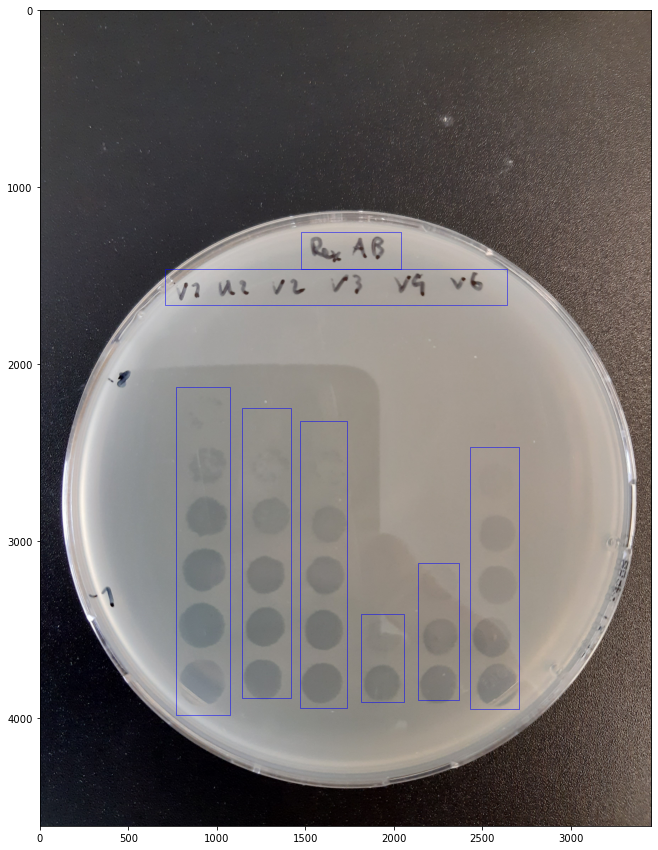

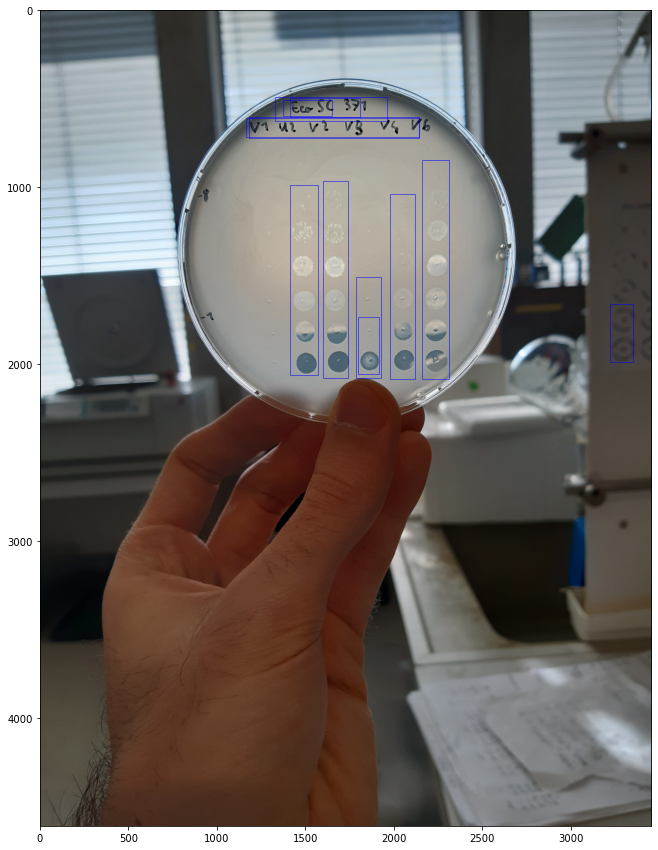

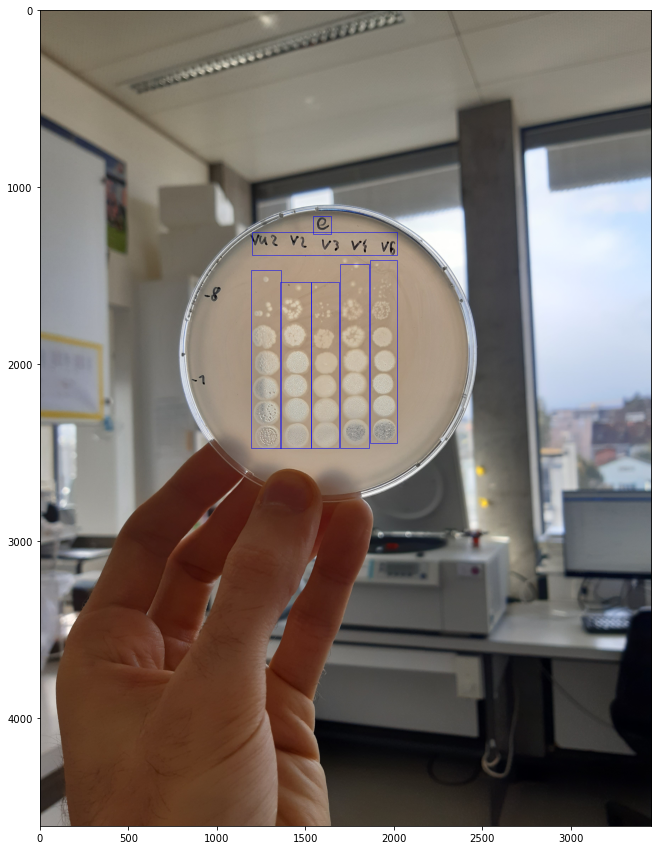

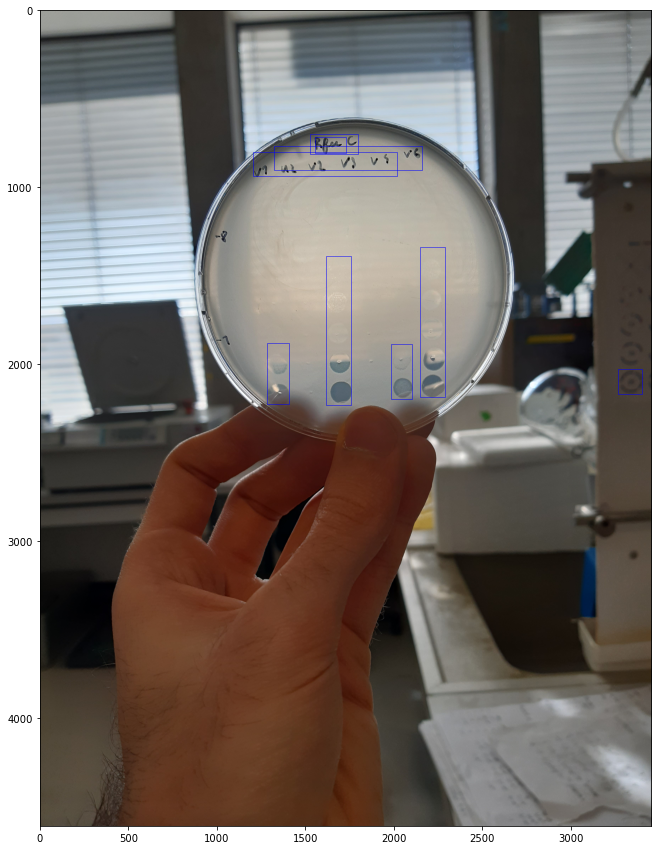

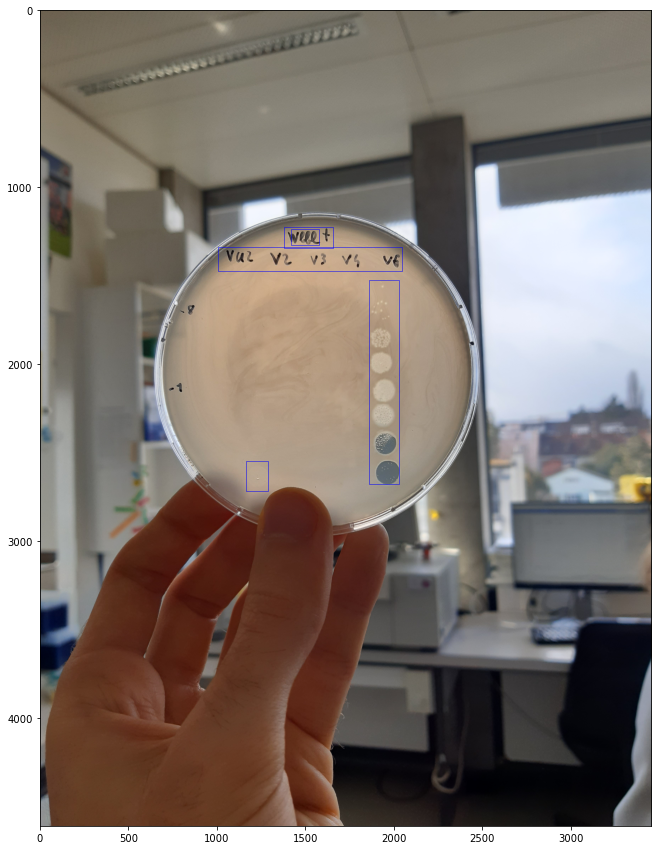

In [11]:
def plot_prediction(image, prediction):
    plt.figure(figsize=(24,15))
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image)
    
    boxes = []
    for box,score in zip(prediction["boxes"].cpu().numpy(), prediction["scores"].cpu().numpy()):
        if score > 0.32:
            boxes += [Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1])]
    pc = PatchCollection(boxes, facecolor="none", edgecolor="blue", alpha=0.5)
    plt.gca().add_collection(pc)
    

model = torch.load("test_save")
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(image.to(device) for image in images)
        targets = [{key: t[key].to(device) for key in t.keys()} for t in targets]
        
        prediction = model(images)
        
        plot_prediction(images[0], prediction[0])
plt.show()